In [ ]:
!pip install pyqubo dimod

In [ ]:
from pyqubo import Array

n_pattern  = 6  # 0:[上、下]、1;[左、右]、2:[上、右]、3:[右、下]、4:[下、左]、5:[左、上]
lattice_size_x = 10
lattice_size_y = 10
v = Array.create('v', shape=(lattice_size_x, lattice_size_y, n_pattern), vartype='BINARY')


In [4]:
import numpy as np
def convert_to_np(result, var, var_label):
    result_np = np.zeros(var.shape, dtype=int)
    for x in range(var.shape[0]):
        for y in range(var.shape[1]):
            for p in range(var.shape[2]):
                result_np[x][y][p] = result[f'{var_label}[{x}][{y}][{p}]']
    success = result_np.sum() == var.shape[0] * var.shape[1]
    result_np = result_np.argmax(axis=-1)
    return success, result_np

In [5]:
import matplotlib.pyplot as plt

def plot(pattern_array, x_size, y_size):
    # 0:[上、下]、1;[左、右]、2:[上、右]、3:[右、下]、4:[下、左]、5:[左、上]
    show_positions = [
        {
            'from': [0.5, 1],
            'to': [0.5, 0]
        },
        {
            'from': [0, 0.5],
            'to': [1, 0.5]
        },
        {
            'from': [0.5, 1],
            'to': [1, 0.5]
        },
        {
            'from': [1, 0.5],
            'to': [0.5, 0]
        },
        {
            'from': [0.5, 0],
            'to': [0, 0.5]
        },
        {
            'from': [0, 0.5],
            'to': [0.5, 1]
        },
    ]
    plt.xlim([0, x_size])
    plt.ylim([0, y_size])
    # plt.xticks(list(range(x_size+1)))
    # plt.yticks(list(range(y_size+1)))
    for x in range(x_size):
        for y in range(y_size):
            p = pattern_array[x][y]
            positions = show_positions[p]
            xs = [x + positions['from'][0], x + positions['to'][0]]
            ys = [y + positions['from'][1], y + positions['to'][1]]
            plt.plot(xs, ys)
    # plt.grid()
    # plt.show()

In [6]:
from pyqubo import Constraint

# 各地点で選べるパターンは一つだけ
H_onehot = 0
for x in range(lattice_size_x):
    for y in range(lattice_size_y):
        tmp = 0
        for p in range(n_pattern):
            tmp += v[x][y][p]
        H_onehot += Constraint((tmp - 1)**2, str(x)+":"+str(y))

In [7]:
# 0:[上、下]、1;[左、右]、2:[上、右]、3:[右、下]、4:[下、左]、5:[左、上]
unconnected_penalty_patterns = [
    [
        {
            "pos": [0, 1],
            "patterns": [1, 2, 5]
        },
        {
            "pos": [0, -1],
            "patterns": [1, 3, 4]
        }
    ],
    [
        {
            "pos": [-1, 0],
            "patterns": [0, 4, 5]
        },
        {
            "pos": [1, 0],
            "patterns": [0, 2, 3]
        }
    ],
    [
        {
            "pos": [0, 1],
            "patterns": [1, 2, 5]
        },
        {
            "pos": [1, 0],
            "patterns": [0, 2, 3]
        }
    ],
    [
        {
            "pos": [1, 0],
            "patterns": [0, 2, 3]
        },
        {
            "pos": [0, -1],
            "patterns": [1, 3, 4]
        }
    ],
    [
        {
            "pos": [0, -1],
            "patterns": [1, 3, 4]
        },
        {
            "pos": [-1, 0],
            "patterns": [0, 4, 5]
        }
    ],
    [
        {
            "pos": [-1, 0],
            "patterns": [0, 4, 5]
        },
        {
            "pos": [0, 1],
            "patterns": [1, 2, 5]
        }
    ],
]

# 接続していなかったらペナルティ
H_unconnected = 0
for x in range(lattice_size_x):
    for y in range(lattice_size_y):
        for p in range(n_pattern):
            penalty_patterns = unconnected_penalty_patterns[p]
            for penalty_pattern in penalty_patterns:
                target_x = x + penalty_pattern["pos"][0]
                target_y = y + penalty_pattern["pos"][1]
                if 0 <= target_x < lattice_size_x and 0 <= target_y < lattice_size_y:
                    for target_pattern in penalty_pattern["patterns"]:
                        H_unconnected += v[x][y][p] * v[target_x][target_y][target_pattern]

In [8]:
import dimod
S = 1
H = 0
H += S * H_onehot
H += H_unconnected
bqm = H.compile().to_bqm()
sampleset = dimod.SimulatedAnnealingSampler().sample(bqm, num_reads=10)
result = sampleset.first.sample

success, pattern_array = convert_to_np(result, v, "v")
assert(success)

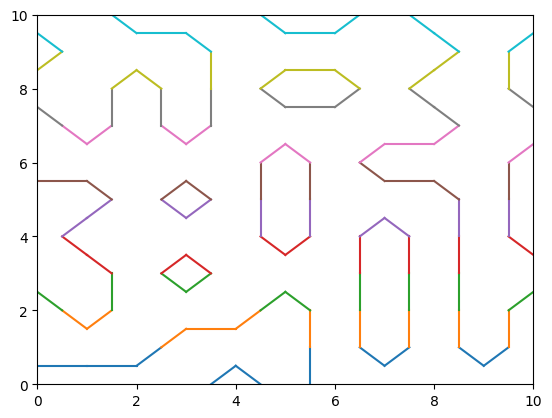

In [9]:
plot(pattern_array, lattice_size_x, lattice_size_y)

In [10]:
## 制約条件を満たしているかの確認
# penalties = np.zeros([lattice_size_x, lattice_size_y])
# for x in range(lattice_size_x):
#     for y in range(lattice_size_y):
#         p = pattern_array[x][y]
#         penalty_patterns = unconnected_penalty_patterns[p]
#         for penalty_pattern in penalty_patterns:
#             target_x = x + penalty_pattern["pos"][0]
#             target_y = y + penalty_pattern["pos"][1]
#             if 0 <= target_x < lattice_size_x and 0 <= target_y < lattice_size_y:
#                 target_p = pattern_array[target_x][target_y]
#                 print(f"{x}:{y}:{p} {target_x}:{target_y}:{target_p} {penalty_pattern['patterns']}")
#                 if target_p in penalty_pattern["patterns"]:
#                     penalties[x][y] += 1
# # 0:[上、下]、1;[左、右]、2:[上、右]、3:[右、下]、4:[下、左]、5:[左、上]
# plt.imshow(penalties)
# plt.grid()
# plt.xlim([0, lattice_size_x])
# plt.ylim([0, lattice_size_y])
# plt.xticks(list(range(lattice_size_x+1)))
# plt.yticks(list(range(lattice_size_y+1)))
# plt.show()

In [11]:
# 外部接続に対してペナルティ
# 0:[上、下]、1;[左、右]、2:[上、右]、3:[右、下]、4:[下、左]、5:[左、上]
penaltiy_patterns_outgoing = {
    "left": [1, 4, 5],
    "right": [1, 2, 3],
    "top": [0, 2, 5],
    "bottom": [0, 3, 4]
}
H_outgoing = 0
for y in range(lattice_size_y):
    # 左端
    for p in penaltiy_patterns_outgoing["left"]:
        H_outgoing += v[0][y][p]
    # 右端
    for p in penaltiy_patterns_outgoing["right"]:
        H_outgoing += v[lattice_size_x - 1][y][p]
for x in range(lattice_size_x):
    # 上端
    for p in penaltiy_patterns_outgoing["bottom"]:
        H_outgoing += v[x][0][p]
    # 下端
    for p in penaltiy_patterns_outgoing["top"]:
        H_outgoing += v[x][lattice_size_y - 1][p]


In [12]:
import dimod
H = 0
H += H_onehot
H += H_outgoing
H += H_unconnected
bqm = H.compile().to_bqm()
sampleset = dimod.SimulatedAnnealingSampler().sample(bqm, num_reads=1)
result = sampleset.first.sample

success, pattern_array = convert_to_np(result, v, "v")
print(success)

True


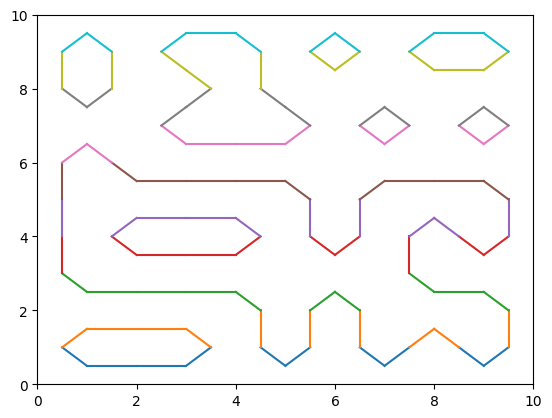

In [13]:
plot(pattern_array, lattice_size_x, lattice_size_y)

In [14]:
# 鋭角に対するペナルティ
# 0:[上、下]、1;[左、右]、2:[上、右]、3:[右、下]、4:[下、左]、5:[左、上]
acute_penalty_patterns = [
    [

    ],
    [

    ],
    [
        {
            "pos": [0, 1],
            "patterns": 3
        },
        {
            "pos": [1, 0],
            "patterns": 5
        }
    ],
    [
        {
            "pos": [1, 0],
            "patterns": 4
        },
        {
            "pos": [0, -1],
            "patterns": 2
        }
    ],
    [
        {
            "pos": [0, -1],
            "patterns": 5
        },
        {
            "pos": [-1, 0],
            "patterns": 3
        }
    ],
    [
        {
            "pos": [-1, 0],
            "patterns": 2
        },
        {
            "pos": [0, 1],
            "patterns": 4
        }
    ],
]
H_acute_penalty = 0
for x in range(lattice_size_x):
    for y in range(lattice_size_y):
        for p in range(n_pattern):
            penalty_patterns = acute_penalty_patterns[p]
            for penalty_pattern in penalty_patterns:
                target_x = x + penalty_pattern["pos"][0]
                target_y = y + penalty_pattern["pos"][1]
                if 0 <= target_x < lattice_size_x and 0 <= target_y < lattice_size_y:
                    target_pattern = penalty_pattern["patterns"]
                    H_acute_penalty += v[x][y][p] * v[target_x][target_y][target_pattern]

In [15]:
import dimod
H = 0
H += H_onehot
H += H_outgoing
H += H_unconnected
H += 0.1*H_acute_penalty
bqm = H.compile().to_bqm()
sampleset = dimod.SimulatedAnnealingSampler().sample(bqm, num_reads=10)
result = sampleset.first.sample

success, pattern_array = convert_to_np(result, v, "v")
# assert(success)
print(success)

True


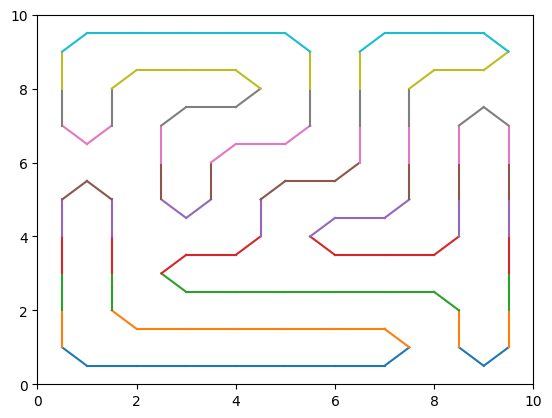

In [16]:
plot(pattern_array, lattice_size_x, lattice_size_y)